# Plastic Simulation

Please read the notebook on [Hardwall Simulation](Hardwall_Simulation.ipynb) before. 


The method is described in 

Weber, B. et al. Molecular probes reveal deviations from Amontons’ law in multi-asperity frictional contacts. Nature Communications 9, 888 (2018).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PyCo.Topography import Topography, PlasticTopography
from PyCo.SolidMechanics import FreeFFTElasticHalfSpace
from ContactMechanics import HardWall
from PyCo.System import make_system
from PyCo.Topography import PlasticTopography
from PyCo.Tools.Logger import screen

## Prepare Geometry

In [2]:
nx, ny = 128,128

sx = 0.005 # mm
sy = 0.005 # mm

x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2

topography= Topography(- np.sqrt(x**2 + y**2 ) *0.05, physical_sizes=(sx, sy) )


Text(0, 0.5, 'y (mm)')

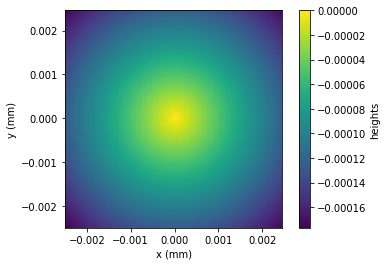

In [3]:
fig, ax = plt.subplots()
plt.colorbar(ax.pcolormesh(x * np.ones_like(y), y * np.ones_like(x), topography.heights()), label = "heights")
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

Text(0, 0.5, 'heights (mm)')

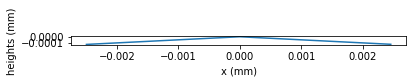

In [4]:
fig, ax = plt.subplots()
ax.plot(x, topography.heights()[:, ny//2])
ax.set_aspect(1)
ax.set_xlabel("x (mm)")
ax.set_ylabel("heights (mm)")

## Material Properties

In [5]:
Es = 230000 # MPa
hardness = 6000 # MPa

## setup system

the `make_system` automatically knows it has to do a plastic simulation if we pass a `PlasticTopogaraphy`

In [6]:
system = make_system( interaction = HardWall(),
            substrate = FreeFFTElasticHalfSpace(nb_grid_pts=topography.nb_grid_pts, young=Es, physical_sizes=topography.physical_sizes), 
            surface= PlasticTopography(topography=topography, hardness=hardness)
           )

#### loading history

In [7]:
external_forces = [0.001, 0.005,0.01, 0.02, 0.01, 0.005, 0.001]

#### optional: provide an initial contition
provide initial disp that is nonzero because otherwise the optimizer will begin with full contact area, 
what is far from the solution in this case

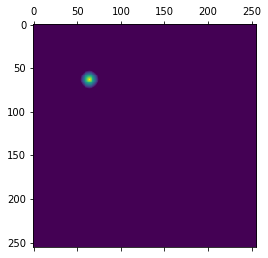

In [8]:
penetration = 0.00002
disp0 = np.zeros(system.substrate.nb_domain_grid_pts)
disp0[system.surface.subdomain_slices] = system.surface.heights() + penetration
disp0 = np.where(disp0 > 0, disp0, 0)
plt.matshow(disp0)

### Simulate

In [9]:
# prepare empty arrays to contain results
offsets = []
plastic_areas = []
contact_areas = []
forces = np.zeros((len(external_forces), *topography.nb_grid_pts)) # forces[timestep,...]: array of forces for each gridpoint
elastic_displacements = np.zeros((len(external_forces), *topography.nb_grid_pts))
plastified_topographies = []

i=0
for external_force in external_forces:
    sol = system.minimize_proxy(external_force=external_force, #load controlled
                                #mixfac = 1e-4,
                                disp0=disp0,
                                pentol=1e-10, # for the default value I had some spiky pressure fields during unloading
                                logger=screen) # display informations about each iteration
    assert sol.success
    disp0 = system.disp
    offsets.append(system.offset)
    plastic_areas.append(system.surface.plastic_area)
    contact_areas.append(system.compute_contact_area())
    
    plastified_topographies.append(system.surface.squeeze())
    #system.surface=PlasticTopography(topography=topography, hardness=hardness) # reset surface
    forces[i,...] = system.force
    elastic_displacements[i, ...] = system.disp[system.surface.subdomain_slices]
    
    i+=1
    #print(np.max(system.surface.plastic_displ))
    #print(np.min(system.surface.plastic_displ))

# {constrained_conjugate_gradients}: maxiter = 100000
# {constrained_conjugate_gradients}: pentol = 1e-10
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   cg         1    2.530000000000e+02    1.544189453125e-02    1.086936456054e-03    2.000000000000e-05    6.900000000000e+01    4.211425781250e-03
                   cg         2    2.530000000000e+02    1.544189453125e-02    1.198198438758e-03    2.046758843494e-05    1.010000000000e+02    6.164550781250e-03
                   cg         3    1.850000000000e+02    1.129150390625e-02    1.165974641301e-03    2.098395286307e-05    1.010000000000e+02    6.164550781250e-03
                   sd         4    1.770000000000e+02    1.080322265625e-02    1.139042144424e-03    2.069333846412e-05    1.010000000000e+02    6.164550781250e-03
                   cg         5    1.610000000000e+02    9.826660156250e-0

# {constrained_conjugate_gradients}: pentol = 1e-10
                   sd         1    8.283000000000e+03    5.055541992188e-01    8.075020854974e-02    9.650741673945e-05    2.569000000000e+03    1.567993164062e-01
                   sd         2    7.573000000000e+03    4.622192382812e-01   -6.124952253193e-02    1.628628904863e-04    4.957000000000e+03    3.025512695312e-01
                   sd         3    3.855000000000e+03    2.352905273438e-01    8.025469093262e-01    4.126635049052e-05    1.374000000000e+03    8.386230468750e-02
                   sd         4    6.902000000000e+03    4.212646484375e-01   -6.454640400067e+00    7.793057362926e-04    6.691000000000e+03    4.083862304688e-01
                   sd         5    9.688000000000e+03    5.913085937500e-01    9.389149547222e+01   -6.887242773157e-03    9.673000000000e+03    5.903930664062e-01
                  mix         6    6.746000000000e+03    4.117431640625e-01    6.115723485250e-02         0    6.680000000000e+0

#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd        47    6.840000000000e+02    4.174804687500e-02    5.078433731880e-03    4.323277811662e-05    4.360000000000e+02    2.661132812500e-02
                   sd        48    6.810000000000e+02    4.156494140625e-02    5.061170591120e-03    4.315040811015e-05    4.330000000000e+02    2.642822265625e-02
                   sd        49    6.810000000000e+02    4.156494140625e-02    5.047978356851e-03    4.307586713636e-05    4.310000000000e+02    2.630615234375e-02
                   sd        50    6.730000000000e+02    4.107666015625e-02    5.037204707106e-03    4.301880120240e-05    4.290000000000e+02    2.618408203125e-02
                   sd        51    6.730000000000e+02    4.107666015625e-02    5.028527695893e-03    4.297258825764e-05    4.240000000000e+02    2.587890625000e-02
                

                   sd        17    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        18    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        19    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        20    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        21    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                

                   sd        63    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        64    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        65    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        66    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        67    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd        68    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                

                   sd       109    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       110    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       111    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd       112    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       113    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                

                   sd       154    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       155    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       156    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       157    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       158    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       159    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                

                   sd       200    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       201    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd       202    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       203    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       204    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                

                   sd       245    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       246    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       247    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       248    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       249    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       250    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                

                   sd       291    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   sd       292    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       293    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       294    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       295    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                

                   sd       336    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       337    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       338    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       339    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       340    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
                   sd       341    8.436000000000e+03    5.148925781250e-01    7.722473144531e-02    1.369367211224e-04    8.435000000000e+03    5.148315429688e-01
#            1:s

                   sd       383    4.852000000000e+03    2.961425781250e-01    2.937414859761e-02    1.059339922379e-04    3.151000000000e+03    1.923217773438e-01
                   sd       384    4.394000000000e+03    2.681884765625e-01    2.530480043113e-02    1.038593664784e-04    2.542000000000e+03    1.551513671875e-01
                   sd       385    4.099000000000e+03    2.501831054688e-01    2.336800093530e-02    9.659984007231e-05    2.396000000000e+03    1.462402343750e-01
                   sd       386    3.668000000000e+03    2.238769531250e-01    2.191261481879e-02    9.265844498291e-05    2.295000000000e+03    1.400756835938e-01
                   sd       387    3.317000000000e+03    2.024536132812e-01    1.964234609596e-02    8.973475904353e-05    1.937000000000e+03    1.182250976562e-01
                   sd       388    3.101000000000e+03    1.892700195312e-01    1.831827262314e-02    8.499640337207e-05    1.864000000000e+03    1.137695312500e-01
                

                   cg       429    1.353000000000e+03    8.258056640625e-02    1.000070989015e-02    6.055952278116e-05    8.530000000000e+02    5.206298828125e-02
                   cg       430    1.353000000000e+03    8.258056640625e-02    1.000055434569e-02    6.055893007797e-05    8.530000000000e+02    5.206298828125e-02
                   cg       431    1.353000000000e+03    8.258056640625e-02    1.000043288940e-02    6.055846688493e-05    8.530000000000e+02    5.206298828125e-02
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   cg       432    1.353000000000e+03    8.258056640625e-02    1.000033804810e-02    6.055810335535e-05    8.530000000000e+02    5.206298828125e-02
                   cg       433    1.353000000000e+03    8.258056640625e-02    1.000026398799e-02    6.055781802700e-05    8.530000000000e+02    5.206298828125e-02
                

                   cg        36    2.693000000000e+03    1.643676757812e-01    2.000909190220e-02    8.566780222059e-05    1.701000000000e+03    1.038208007812e-01
                   cg        37    2.693000000000e+03    1.643676757812e-01    2.000708245914e-02    8.566229185440e-05    1.701000000000e+03    1.038208007812e-01
                   cg        38    2.687000000000e+03    1.640014648438e-01    2.000552739538e-02    8.565798450436e-05    1.701000000000e+03    1.038208007812e-01
                   cg        39    2.685000000000e+03    1.638793945312e-01    2.000430900904e-02    8.565469082190e-05    1.701000000000e+03    1.038208007812e-01
                   cg        40    2.685000000000e+03    1.638793945312e-01    2.000335905174e-02    8.565210429337e-05    1.701000000000e+03    1.038208007812e-01
                   cg        41    2.685000000000e+03    1.638793945312e-01    2.000261723361e-02    8.565012133793e-05    1.701000000000e+03    1.038208007812e-01
                

                   cg        29    1.757000000000e+03    1.072387695312e-01    1.000000000000e-02    6.433739581418e-05    0.000000000000e+00    0.000000000000e+00
                   cg        30    1.757000000000e+03    1.072387695312e-01    1.000000000000e-02    6.433781230147e-05    0.000000000000e+00    0.000000000000e+00
#            1:status      2:it                3:area          4:frac. area         5:total force              6:offset         7:plast. area    8:frac.plast. area
                   cg        31    1.757000000000e+03    1.072387695312e-01    1.000000000000e-02    6.433764973551e-05    0.000000000000e+00    0.000000000000e+00
                   cg        32    1.757000000000e+03    1.072387695312e-01    1.000000000000e-02    6.433757248214e-05    0.000000000000e+00    0.000000000000e+00
                   cg        33    1.757000000000e+03    1.072387695312e-01    1.000000000000e-02    6.433766329663e-05    0.000000000000e+00    0.000000000000e+00
                

                   cg        34    1.305000000000e+03    7.965087890625e-02    5.000000000000e-03    5.177749876406e-05    0.000000000000e+00    0.000000000000e+00
            CONVERGED        35    1.305000000000e+03    7.965087890625e-02    5.000000000000e-03    5.177749940863e-05    0.000000000000e+00    0.000000000000e+00
# {constrained_conjugate_gradients}: maxiter = 100000
# {constrained_conjugate_gradients}: pentol = 1e-10
                   sd         1    8.709000000000e+03    5.315551757812e-01    5.129292375359e-02    9.761418069260e-05    2.635000000000e+03    1.608276367188e-01
                   sd         2    7.253000000000e+03    4.426879882812e-01    3.353041093410e-02    1.347460450911e-04    4.060000000000e+03    2.478027343750e-01
                   sd         3    6.462000000000e+03    3.944091796875e-01    2.672606402279e-02    1.121793112875e-04    2.890000000000e+03    1.763916015625e-01
                   sd         4    5.004000000000e+03    3.054199218750e-0

## plot pressure distributions and deformed profiles

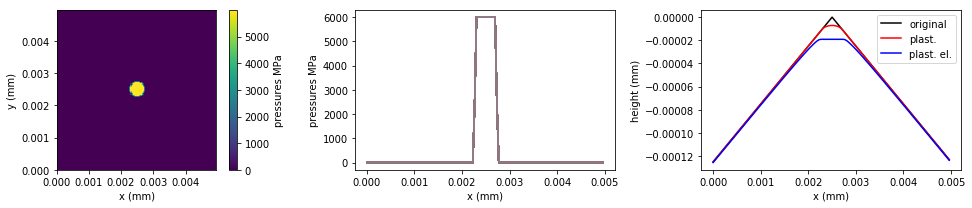

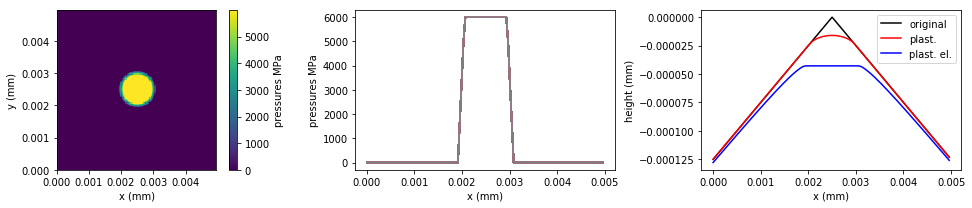

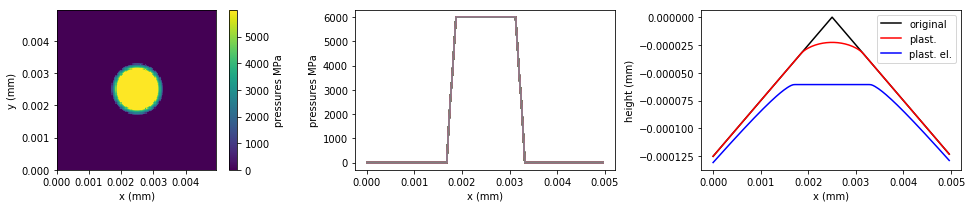

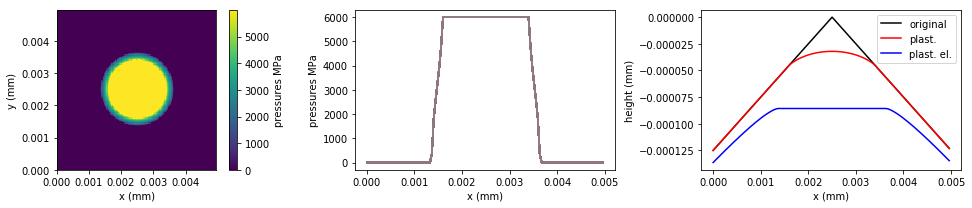

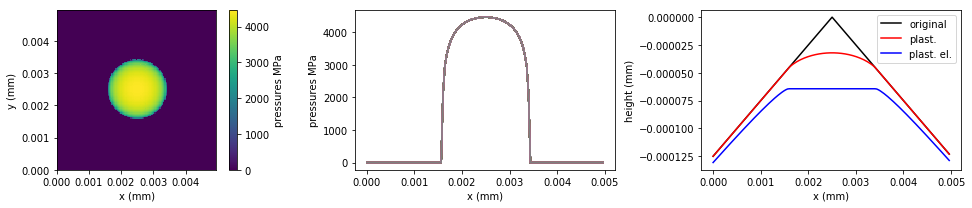

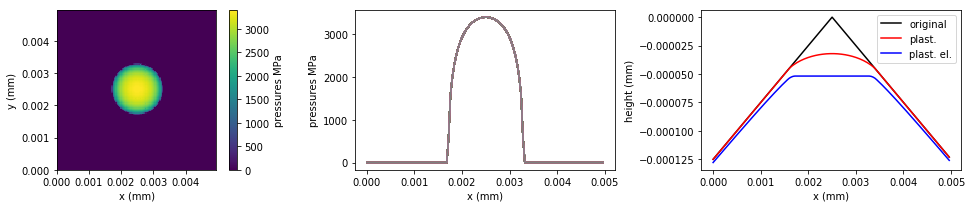

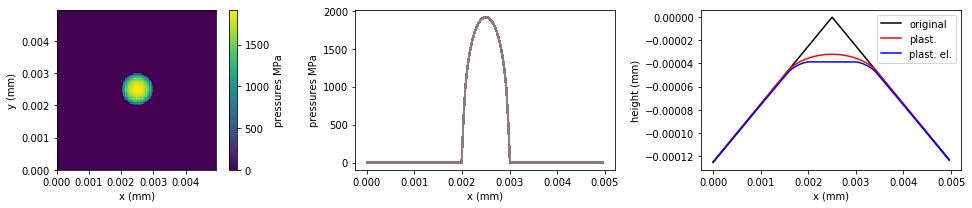

In [22]:
for i in range(len(external_forces)):
    
    fig, (axf, axfcut, axtopcut) = plt.subplots(1,3, figsize=(14,3))
    
    axf.set_xlabel("x (mm)")
    axf.set_ylabel("y (mm)")
        
    axfcut.plot(system.surface.positions()[0], forces[i, :, ny//2]/ system.area_per_pt)
    axfcut.set_xlabel("x")
    axfcut.set_ylabel("pressures MPa")
    
    for a in (axfcut, axtopcut):
        a.set_xlabel("x (mm)")
    axtopcut.set_ylabel("height (mm)")
    
    plt.colorbar(axf.pcolormesh(*system.surface.positions(), forces[i,...]/ system.area_per_pt), label="pressures MPa", ax = axf)
    axf.set_aspect(1)
    
    axtopcut.plot(system.surface.positions()[0][:,0], topography.heights()[:, ny//2], 
                  color="k", label = "original")
    axtopcut.plot(system.surface.positions()[0][:,0], plastified_topographies[i].heights()[:, ny//2], 
                  color = "r", label="plast.")
    axtopcut.plot(system.surface.positions()[0][:,0], plastified_topographies[i].heights()[:, ny//2] - elastic_displacements[i,:, ny//2], 
                  c="b", label="plast. el.")
    axtopcut.legend()
    
    fig.tight_layout()

## scalar quantities during loading

Text(0, 0.5, 'Force [N]')

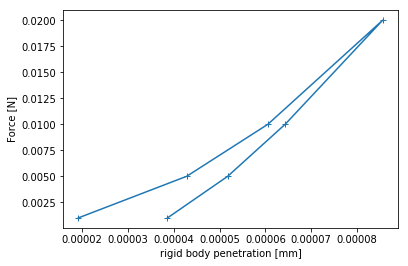

In [23]:
fig, ax = plt.subplots()

ax.plot(offsets, external_forces,"+-")
ax.set_xlabel("rigid body penetration [mm]")
ax.set_ylabel("Force [N]")

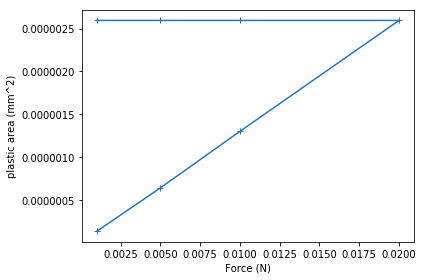

In [24]:
fig, ax = plt.subplots()

ax.plot(external_forces, plastic_areas, "-+")
ax.set_xlabel("Force (N)")
ax.set_ylabel("plastic area (mm^2)")
fig.tight_layout()

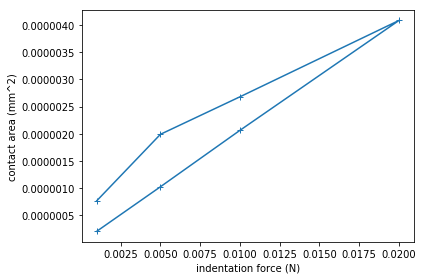

In [25]:
fig, ax = plt.subplots()

ax.plot(external_forces, contact_areas, "+-")
ax.set_xlabel("indentation force (N)")
ax.set_ylabel("contact area (mm^2)")
fig.tight_layout()